# ML Sales Forecasting

In [ ]:
import glob
import math
import re
import warnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import set_config

from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
sns.set_style(style='whitegrid')

In [3]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [4]:
def print_correlation_matrix(df):    
    corr = df.corr(numeric_only=True)
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.show()

In [5]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.isocalendar().week
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

In [6]:
def create_groupped_analysis(col, df):
    unique_values = df[[col, 'Weekly_Sales']].groupby(by=col).mean().size
    print(f'The number of unique values on the category \'{col}\' is {unique_values}\n')
    print('-' * 40)
    print(f'The top 5 \'{col}\' with higher average \'Weekly_Sales\':')
    print('-' * 40)
    return (
        df[[col, 'Weekly_Sales']]
        .groupby(by=col)
        .mean()
        .sort_values('Weekly_Sales', ascending=False)
        .head()
    )

In [7]:
def plot_groupped_graph(col1, col2, df):
    if col2:
        df = (
            df[[col1, col2, 'Weekly_Sales']]
            .groupby([col1, col2])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )
    else:
        df = (
            df[[col1, 'Weekly_Sales']]
            .groupby([col1])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )

    df.reset_index(inplace=True)
    sns.relplot(
        x=col1,
        y='Weekly_Sales',
        hue=col2,
        data=df.sort_values(col1),
        height=5,
        aspect=2
    )

In [8]:
def plot_regression_results(y_true, y_pred, title, scores):
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [9]:
def plot_features_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [10]:
def model_factory(model_type, **kwargs):
    if model_type in ['RandomForestRegressor'] :
        n_estimators = kwargs.get('n_estimators')
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')
        
        if n_estimators is None:   
            n_estimators = 50
        
        verbose = 0 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'XGBRegressor':
        return XGBRegressor()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    else:
        raise ValueError('Model not defined on factory.')

<div id="descriptive-analysis"/>

# Descriptive Analysis


### Reading the provided data and checking data format and structure

In [11]:
# Get the current working directory
base_path = os.getcwd()

# Find all CSV files in the current directory
input_paths = glob.glob(os.path.join(base_path, '*.csv'))
print(input_paths)


input_dfs = {
    re.search(r'forecasting\/(.*)\.csv', path, re.IGNORECASE)[1] : pd.read_csv(path)
    for path in input_paths
}

# In this data structure, we have a dict and we can access each dataframe by its key
input_dfs.keys()

['/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv', '/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/test.csv', '/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/submission.csv', '/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/train.csv', '/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/features.csv', '/Users/joshualee/Desktop/walmart-recruiting-store-sales-forecasting/stores.csv']


dict_keys(['sampleSubmission', 'test', 'submission', 'train', 'features', 'stores'])

In [12]:
# Checking data format and structure
df_train = input_dfs['features'].merge(input_dfs['stores'], how='left', on='Store')
df_train = input_dfs['train'].merge(df_train, how='left', on=['Store', 'Date', 'IsHoliday'])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


### Checking some basic descriptive statistics and data distribution

* Considering this first analysis, we can see outliers and `NaN` values on a few columns.

In [13]:
df_train.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570,421570.000000
unique,NaN,NaN,143,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,2011-12-23,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,3027,NaN,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215478,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,NaN,136727.915739
std,12.785297,30.492054,NaN,22711.183519,NaN,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,NaN,60980.583328
min,1.000000,1.000000,NaN,-4988.940000,NaN,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,NaN,34875.000000
25%,11.000000,18.000000,NaN,2079.650000,NaN,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,NaN,93638.000000
50%,22.000000,37.000000,NaN,7612.030000,NaN,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,NaN,140167.000000
75%,33.000000,74.000000,NaN,20205.852500,NaN,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,NaN,202505.000000


### Checking the `NaN` percentage in each column



In [14]:
# Checking the NaN percentage
df_train.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

In [15]:
df_train.dropna(axis='columns', inplace=True)

## Correlation Matrix


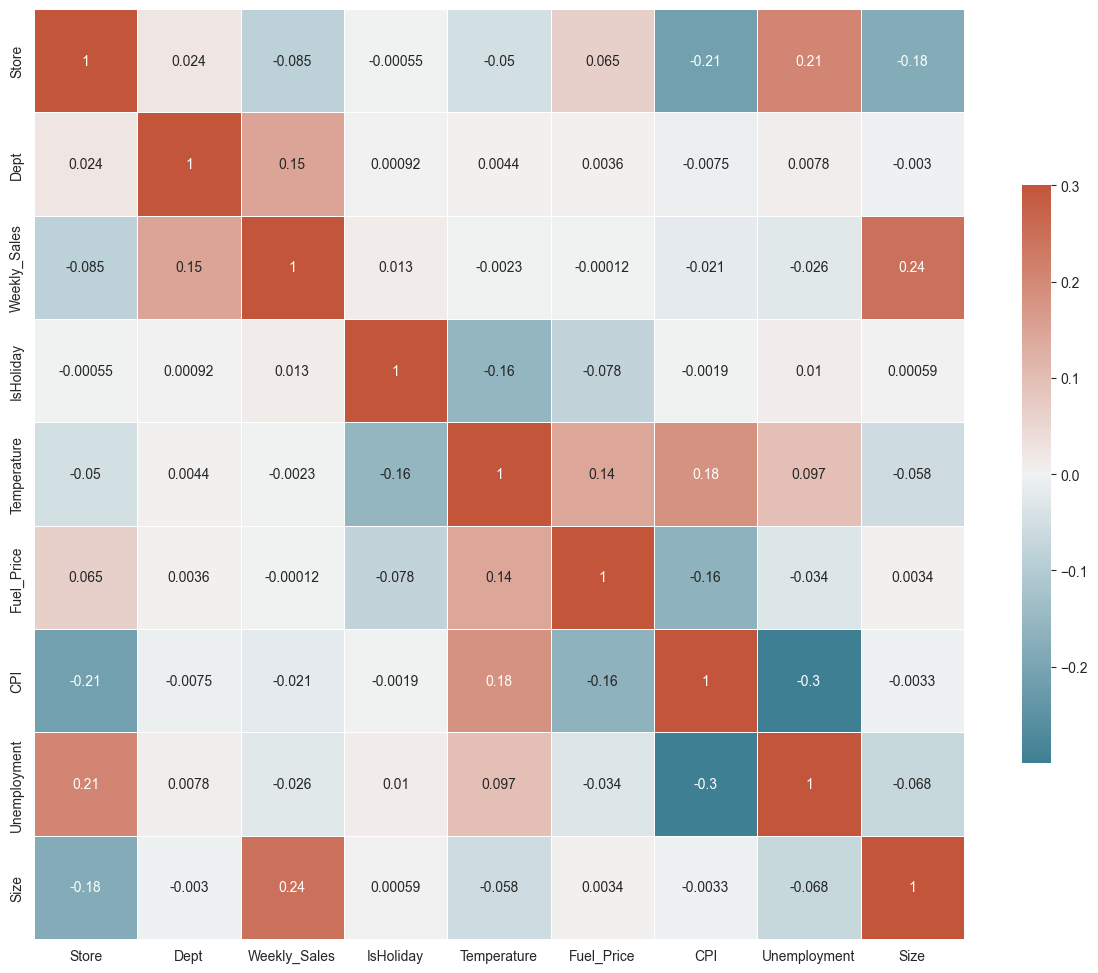

In [16]:
print_correlation_matrix(df_train)

* Dropping features with lower correlation

In [17]:
df_train.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI'], axis=1, inplace=True)

<div id="feature-engineering"/>
    
# Feature Engineering


In [24]:
def create_features(df):

    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1
    
    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])

    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.isocalendar().week
    df['Year'] =  df.Date.dt.year
    df['Month'] =  df.Date.dt.month
    
    # Convert all columns to float
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

In [25]:
create_features(df_train)

<div id="preprocessing"/>

# Data Preprocessing


In [26]:
# Divide dataset for training
X = df_train.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_train['Weekly_Sales']

In [ ]:
categorical_features = X.columns[X.dtypes == 'O']
numeric_features = X.columns[X.dtypes == 'float64']

categories = [X[column].unique() for column in X[categorical_features]]
for cat in categories:
    cat[cat == None] = 'missing'

transform_categorical_features = make_pipeline(
    # Fill all NaN values to missing
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OrdinalEncoder(categories=categories)
)

transform_numeric_features = make_pipeline(
    # Fill all NaN values to -1
    SimpleImputer(strategy='constant', fill_value=-9999),
    StandardScaler()
)

preprocessing_step = make_column_transformer(
    (transform_categorical_features, categorical_features),
    (transform_numeric_features, numeric_features),
    remainder='passthrough'
)

<div id="training"/>

# Training


In [28]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<div id="best-ml-model"/>

Find the best ML model type


In [29]:
regression_models = [
    'LinearRegression',
    'KNN',
    'XGBRegressor',
    'RandomForestRegressor',
]

best_model = None
best_error = math.inf

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


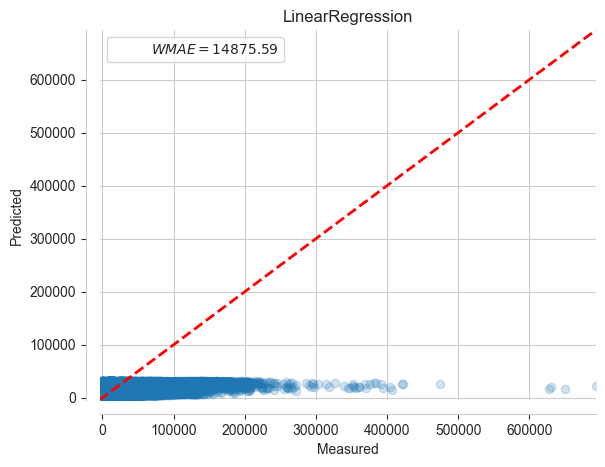

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


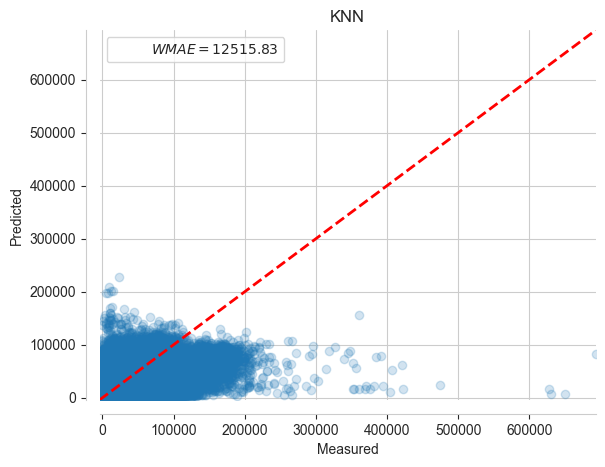

--------------------------------------------------
:: XGBRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


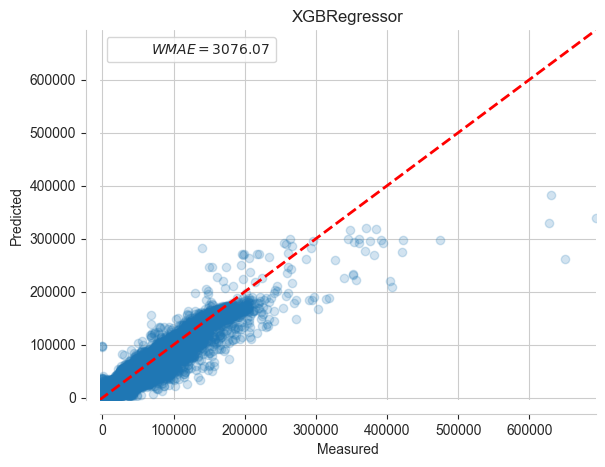

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.2s finished


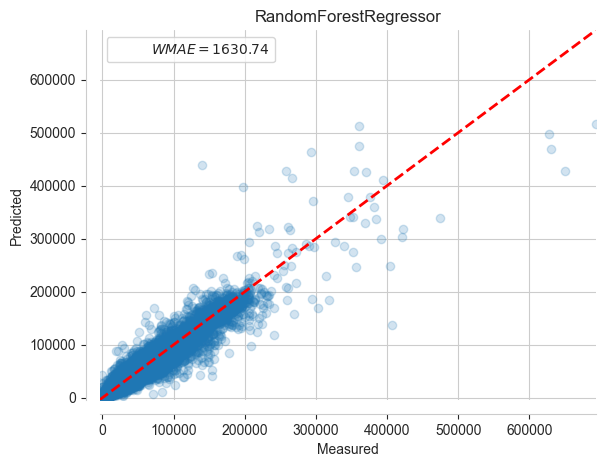

--------------------------------------------------


In [30]:
print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)
    training_pipeline = make_pipeline(
        preprocessing_step,
        regressor
    )

    kfold = KFold(n_splits=3)
    
    y_pred = cross_val_predict(
        training_pipeline,
        X_train,
        y_train,
        cv = kfold,
        n_jobs = -1,
        verbose = 1
    )
    
    wmae_metric = WMAE(X_train, y_train, y_pred)
    
    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name
    
    plot_regression_results(
        y_train,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [31]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 1630.74


<div id="best-hyperparameter"/>

## Find the best hyperparameter combination


In [32]:
# The number of trees in the forest
n_estimators = [x for x in range(50, 250, 50)]

# Create the random grid
random_grid = {
    'model__n_estimators': n_estimators
}

random_grid

{'model__n_estimators': [50, 100, 150, 200]}

In [34]:
def get_best_model_parameters(random_grid, X, y):
    if best_model in ['RandomForestRegressor']:
        model = model_factory(best_model)
    else:
        # grid search not implemented for other models
        return {'model__n_estimators': None}

    grid_pipeline =  Pipeline(
        [("preprocessing", preprocessing_step),
         ("model", model)]
    )

    kfold = KFold(n_splits=3)

    model_random = GridSearchCV(
        grid_pipeline,
        param_grid = random_grid,
        cv = kfold,
        verbose = 2,
        n_jobs = -1
    )

    # Create a sample to speed up parameter search
    X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9)
    return model_random.fit(X_sample, y_sample).best_params_

# Best Parameter combination
best_params = get_best_model_parameters(random_grid, X, y)
best_params

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................model__n_estimators=50; total time=   3.6s
[CV] END .............................model__n_estimators=50; total time=   3.6s
[CV] END .............................model__n_estimators=50; total time=   3.6s
[CV] END ............................model__n_estimators=100; total time=   7.2s
[CV] END ............................model__n_estimators=100; total time=   7.3s
[CV] END ............................model__n_estimators=100; total time=   7.3s
[CV] END ............................model__n_estimators=150; total time=  10.0s
[CV] END ............................model__n_estimators=150; total time=   9.9s
[CV] END ............................model__n_estimators=150; total time=  10.0s
[CV] END ............................model__n_estimators=200; total time=  11.9s
[CV] END ............................model__n_estimators=200; total time=  12.0s
[CV] END ............................model__n_est

{'model__n_estimators': 100}

<div id="training-full-dataset"/>

## Training the full dataset


In [35]:
print('-' * 70)
print(f'Best Model: {best_model}: {best_params}\n')
print('Tip: click on the Pipeline diagram below to have a better view of each step.')
print('-' * 70)

model = model_factory(
    best_model,
    n_estimators = best_params['model__n_estimators'],
    verbose = 1,
    n_jobs = -1
)

best_model_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_step),
        ("model", model)
    ]
)

set_config(display='diagram')
best_model_pipeline.fit(X_train, y_train)

----------------------------------------------------------------------
Best Model: RandomForestRegressor: {'model__n_estimators': 100}

Tip: click on the Pipeline diagram below to have a better view of each step.
----------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values=None,
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['A', 'B', 'C'], dtype=object)]))]),
                                                  Index(['Type'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Store', 'Dept', 'Size', 'HolidayType'], dtype='object'))])),
                ('model', RandomForestRegressor(n_jobs=-1, verbose=1))])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


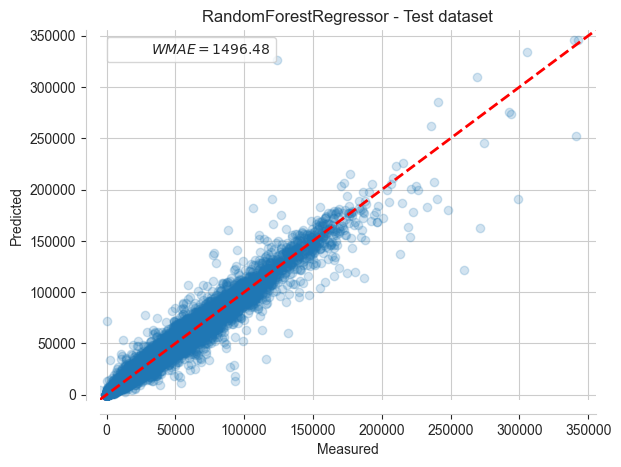

In [36]:
y_pred = best_model_pipeline.predict(X_test)
wmae_metric = WMAE(X_test, y_test, y_pred)

plot_regression_results(
    y_test,
    y_pred,
    f'{best_model} - Test dataset',
    (r'$WMAE ={:.2f}$').format(wmae_metric)
)

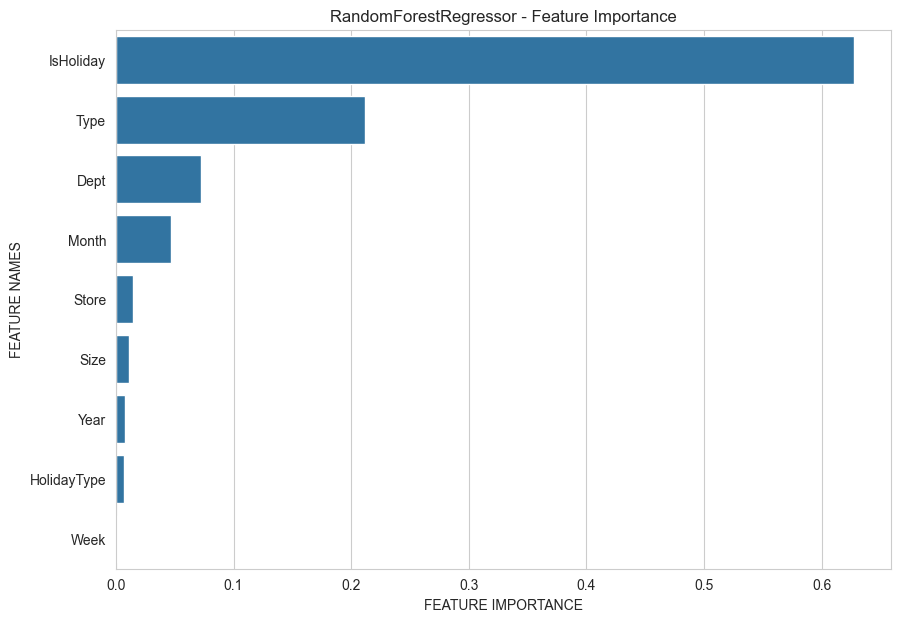

In [37]:
features_importance = best_model_pipeline.steps[1][1].feature_importances_
    
plot_features_importance(
    features_importance,
    X_test.columns,
    best_model
)

<div id="testing"/>

# Testing our Model



In [38]:
# Creates df_test dataset
df_test = input_dfs['features'].merge(input_dfs['stores'], how='left', on='Store')
df_test = input_dfs['test'].merge(df_test, how='left', on=['Store', 'Date', 'IsHoliday'])
create_features(df_test)
df_test = df_test[list(X_train.columns)]
df_test.head()

,Store,Dept,IsHoliday,Type,Size,Week,Month,Year,HolidayType
0,1.0,1.0,False,A,151315.0,44,11,2012,-1.0
1,1.0,1.0,False,A,151315.0,45,11,2012,-1.0
2,1.0,1.0,False,A,151315.0,46,11,2012,-1.0
3,1.0,1.0,True,A,151315.0,47,11,2012,2.0
4,1.0,1.0,False,A,151315.0,48,11,2012,-1.0


In [39]:
y_pred = best_model_pipeline.predict(df_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
